In [ ]:
import collections
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [ ]:
import os
def load_data(path):
    data_file = os.path.join(path)
    with open(data_file,"r") as f:
        lang_data = f.read()
    return lang_data.split('\n')


In [ ]:
# Load English data
english_sentences = load_data('data/small_vocab_en.txt')
# Load French data
french_sentences = load_data('data/small_vocab_fr.txt')
print('Dataset Loaded')

Dataset Loaded


In [ ]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


In [ ]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [ ]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [ ]:
# Tokenize English and French data
input_tensor, inp_tokenizer = tokenize(english_sentences)
target_tensor, targ_tokenizer = tokenize(french_sentences)


In [ ]:
print("\nEnglish Word Index:")
print(dict(list(inp_tokenizer.word_index.items())[:20]))  # Print first 20 for readability

print("\nFrench Word Index:")
print(dict(list(targ_tokenizer.word_index.items())[:20]))

# Print a few tokenized examples
print("\nSample Tokenized English Sentences:")
for i in range(3):
    print(f"{i+1}: {english_sentences[i]}")
    print(f"   → {input_tensor[i]}")

print("\nSample Tokenized French Sentences:")
for i in range(3):
    print(f"{i+1}: {french_sentences[i]}")
    print(f"   → {target_tensor[i]}")


English Word Index:
{'is': 1, 'in': 2, 'it': 3, 'during': 4, 'the': 5, 'but': 6, 'and': 7, 'sometimes': 8, 'usually': 9, 'never': 10, 'favorite': 11, 'least': 12, 'fruit': 13, 'most': 14, 'loved': 15, 'liked': 16, 'new': 17, 'paris': 18, 'india': 19, 'united': 20}

French Word Index:
{'est': 1, 'en': 2, 'il': 3, 'les': 4, 'mais': 5, 'et': 6, 'la': 7, 'parfois': 8, 'jamais': 9, 'le': 10, "l'": 11, 'généralement': 12, 'moins': 13, 'aimé': 14, 'au': 15, 'fruit': 16, 'préféré': 17, 'agréable': 18, 'froid': 19, 'son': 20}

Sample Tokenized English Sentences:
1: new jersey is sometimes quiet during autumn , and it is snowy in april .
   → [17, 23, 1, 8, 67, 4, 39, 7, 3, 1, 55, 2, 44]
2: the united states is usually chilly during july , and it is usually freezing in november .
   → [5, 20, 21, 1, 9, 62, 4, 43, 7, 3, 1, 9, 51, 2, 45]
3: california is usually quiet during march , and it is usually hot in june .
   → [22, 1, 9, 67, 4, 38, 7, 3, 1, 9, 68, 2, 34]

Sample Tokenized French Sentence

In [ ]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

#tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [ ]:
# Pad the tokenized English and French sentences
input_tensor = pad(input_tensor)
target_tensor = pad(target_tensor)

# Get max sequence lengths
max_length_inp = input_tensor.shape[1]
max_length_targ = target_tensor.shape[1]

# Print info and a few padded samples
print(f"Max length of English sequences: {max_length_inp}")
print(f"Max length of French sequences: {max_length_targ}")

print("\nSample Padded English Sentences:")
for i in range(3):
    print(f"{i+1}: {input_tensor[i]}")

print("\nSample Padded French Sentences:")
for i in range(3):
    print(f"{i+1}: {target_tensor[i]}")


Max length of English sequences: 15
Max length of French sequences: 21

Sample Padded English Sentences:
1: [17 23  1  8 67  4 39  7  3  1 55  2 44  0  0]
2: [ 5 20 21  1  9 62  4 43  7  3  1  9 51  2 45]
3: [22  1  9 67  4 38  7  3  1  9 68  2 34  0  0]

Sample Padded French Sentences:
1: [ 35  34   1   8  67  37  11  24   6   3   1 112   2  50   0   0   0   0
   0   0   0]
2: [ 4 32 31  1 12 19  2 49  6  3 95 69  2 51  0  0  0  0  0  0  0]
3: [101   1  12  67   2  45   6   3   1  12  21   2  41   0   0   0   0   0
   0   0   0]


In [ ]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)

max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)+1

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 345


In [ ]:
print(preproc_french_sentences)

[[[ 35]
  [ 34]
  [  1]
  ...
  [  0]
  [  0]
  [  0]]

 [[  4]
  [ 32]
  [ 31]
  ...
  [  0]
  [  0]
  [  0]]

 [[101]
  [  1]
  [ 12]
  ...
  [  0]
  [  0]
  [  0]]

 ...

 [[  7]
  [ 33]
  [  1]
  ...
  [  0]
  [  0]
  [  0]]

 [[ 84]
  [  1]
  [ 20]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]]


In [ ]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, Dense, Input, TimeDistributed, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [ ]:


def stacked_rnn_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])

    # First RNN layer
    rnn_1 = SimpleRNN(64, return_sequences=True)(input_seq)

    # Second RNN layer
    rnn_2 = SimpleRNN(64, return_sequences=True)(rnn_1)

    # Output layer
    logits = TimeDistributed(Dense(french_vocab_size))(rnn_2)

    # Compile the model
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model


In [ ]:
def stacked_lstm_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])

    # First LSTM layer
    lstm_1 = LSTM(64, return_sequences=True)(input_seq)

    # Second LSTM layer
    lstm_2 = LSTM(64, return_sequences=True)(lstm_1)

    # Output layer
    logits = TimeDistributed(Dense(french_vocab_size))(lstm_2)

    # Compile the model
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model


In [ ]:
def stacked_gru_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])

    # First GRU layer
    gru_1 = GRU(64, return_sequences=True)(input_seq)

    # Second GRU layer
    gru_2 = GRU(64, return_sequences=True)(gru_1)

    # Output layer
    logits = TimeDistributed(Dense(french_vocab_size))(gru_2)

    # Compile the model
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model


In [ ]:
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))  # Adding one more dimension for RNN layers
print(tmp_x.shape[1:])


(21, 1)


In [ ]:
# Train the Stacked RNN Model
rnn_model = stacked_rnn_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)
rnn_model.summary()
rnn_history = rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=50, validation_split=0.2)



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 21, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 21, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 21, 345)        │        22,425 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,905 (136.35 KB)

 Trainable params: 34,905 (136.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.5909 - loss: 1.7051 - val_accuracy: 0.6649 - val_loss: 1.1252
Epoch 2/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6883 - loss: 1.0711 - val_accuracy: 0.7183 - val_loss: 0.9508
Epoch 3/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7177 - loss: 0.9429 - val_accuracy: 0.7328 - val_loss: 0.8812
Epoch 4/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7293 - loss: 0.8835 - val_accuracy: 0.7288 - val_loss: 0.8660
Epoch 5/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7361 - loss: 0.8470 - val_accuracy: 0.7500 - val_loss: 0.8089
Epoch 6/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7429 - loss: 0.8171 - val_accuracy: 0.7487 - val_loss: 0.7895
Epoch 7/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.7501 - loss: 0.7874 - val_accuracy: 0.7572 - val_loss: 0.7698
Epoch 8/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.7546 - loss: 0

In [ ]:
# Train the Stacked LSTM Model
lstm_model = stacked_lstm_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)
lstm_model.summary()
lstm_history = lstm_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=50, validation_split=0.2)




Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 21, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 21, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 21, 345)        │        22,425 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,345 (282.60 KB)

 Trainable params: 72,345 (282.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.5665 - loss: 1.8543 - val_accuracy: 0.6909 - val_loss: 1.0756
Epoch 2/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.7011 - loss: 1.0128 - val_accuracy: 0.7258 - val_loss: 0.8865
Epoch 3/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.7272 - loss: 0.8719 - val_accuracy: 0.7381 - val_loss: 0.8235
Epoch 4/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.7404 - loss: 0.8085 - val_accuracy: 0.7546 - val_loss: 0.7611
Epoch 5/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.7533 - loss: 0.7582 - val_accuracy: 0.7593 - val_loss: 0.7459
Epoch 6/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.7660 - loss: 0.7186 - val_accuracy: 0.7724 - val_loss: 0.7027
Epoch 7/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.7768 - loss: 0.6852 - val_accuracy: 0.7850 - val_loss: 0.6619
Epoch 8/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.7854 - loss: 0

In [ ]:
# Train the Stacked GRU Model
gru_model = stacked_gru_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)
gru_model.summary()
gru_history = gru_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=50, validation_split=0.2)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 21, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 21, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 21, 345)        │        22,425 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,249 (235.35 KB)

 Trainable params: 60,249 (235.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.5818 - loss: 1.7686 - val_accuracy: 0.6924 - val_loss: 1.0453
Epoch 2/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - accuracy: 0.7011 - loss: 0.9981 - val_accuracy: 0.7115 - val_loss: 0.9157
Epoch 3/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7208 - loss: 0.8996 - val_accuracy: 0.7335 - val_loss: 0.8533
Epoch 4/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7324 - loss: 0.8447 - val_accuracy: 0.7487 - val_loss: 0.7959
Epoch 5/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7451 - loss: 0.7970 - val_accuracy: 0.7597 - val_loss: 0.7562
Epoch 6/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7544 - loss: 0.7645 - val_accuracy: 0.7614 - val_loss: 0.7355
Epoch 7/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7600 - loss: 0.7439 - val_accuracy: 0.7698 - val_loss: 0.7094
Epoch 8/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7706 - loss: 0

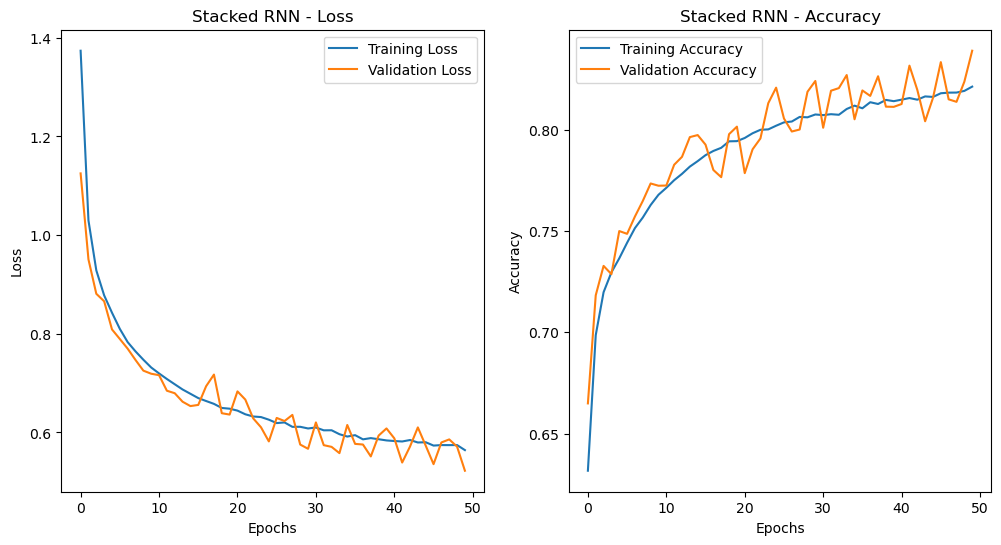

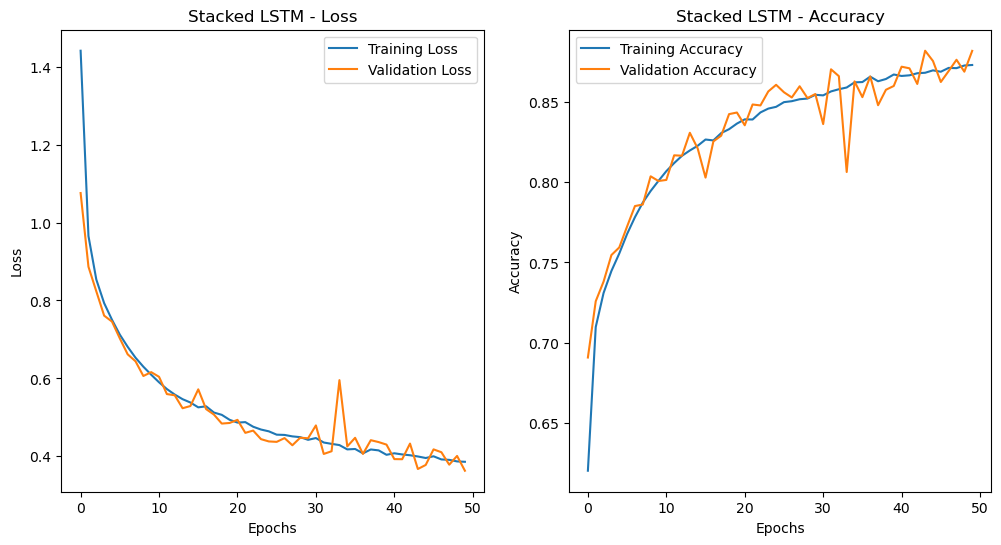

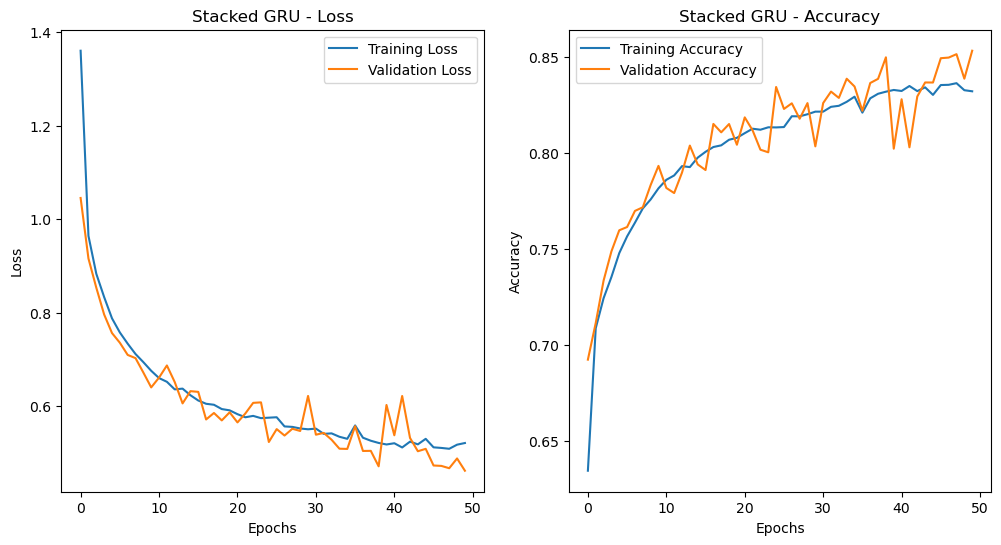

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot for the RNN model
plot_history(rnn_history, "Stacked RNN")

# Plot for the LSTM model
plot_history(lstm_history, "Stacked LSTM")

# Plot for the GRU model
plot_history(gru_history, "Stacked GRU")


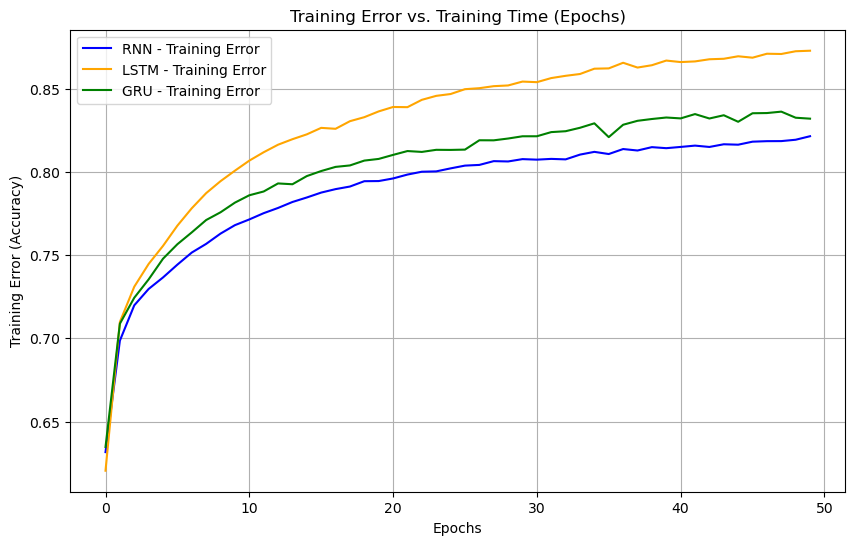

In [ ]:
import matplotlib.pyplot as plt

def plot_training_error_all_models(rnn_history, lstm_history, gru_history):
    plt.figure(figsize=(10, 6))

    # Plot Training Error (Accuracy) for RNN
    plt.plot(rnn_history.history['accuracy'], label='RNN - Training Error', color='blue')

    # Plot Training Error (Accuracy) for LSTM
    plt.plot(lstm_history.history['accuracy'], label='LSTM - Training Error', color='orange')

    # Plot Training Error (Accuracy) for GRU
    plt.plot(gru_history.history['accuracy'], label='GRU - Training Error', color='green')

    plt.title('Training Error vs. Training Time (Epochs)')
    plt.xlabel('Epochs')
    plt.ylabel('Training Error (Accuracy)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of plotting for all three models
plot_training_error_all_models(rnn_history, lstm_history, gru_history)


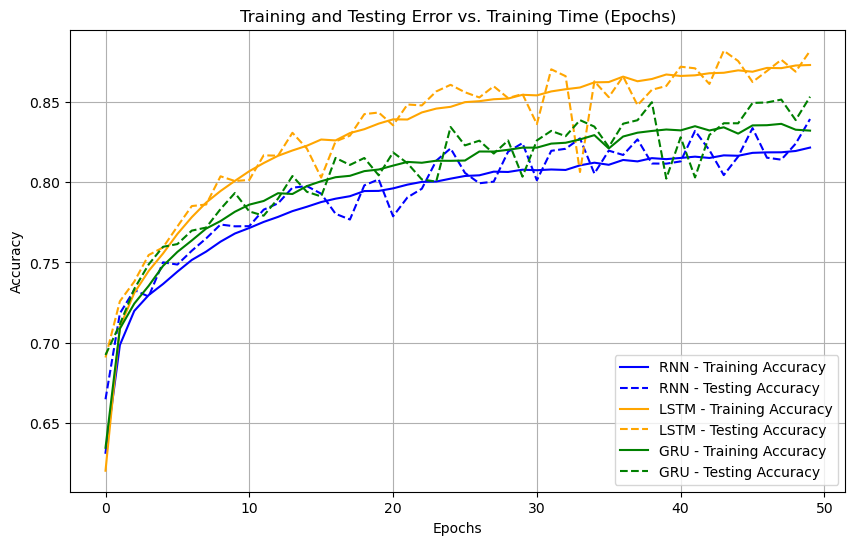

In [ ]:
def plot_training_testing_error_all_models(rnn_history, lstm_history, gru_history):
    plt.figure(figsize=(10, 6))

    # Plot Training and Testing Error for RNN
    plt.plot(rnn_history.history['accuracy'], label='RNN - Training Accuracy', color='blue')
    plt.plot(rnn_history.history['val_accuracy'], label='RNN - Testing Accuracy', color='blue', linestyle='--')

    # Plot Training and Testing Error for LSTM
    plt.plot(lstm_history.history['accuracy'], label='LSTM - Training Accuracy', color='orange')
    plt.plot(lstm_history.history['val_accuracy'], label='LSTM - Testing Accuracy', color='orange', linestyle='--')

    # Plot Training and Testing Error for GRU
    plt.plot(gru_history.history['accuracy'], label='GRU - Training Accuracy', color='green')
    plt.plot(gru_history.history['val_accuracy'], label='GRU - Testing Accuracy', color='green', linestyle='--')

    plt.title('Training and Testing Error vs. Training Time (Epochs)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of plotting for all three models
plot_training_testing_error_all_models(rnn_history, lstm_history, gru_history)


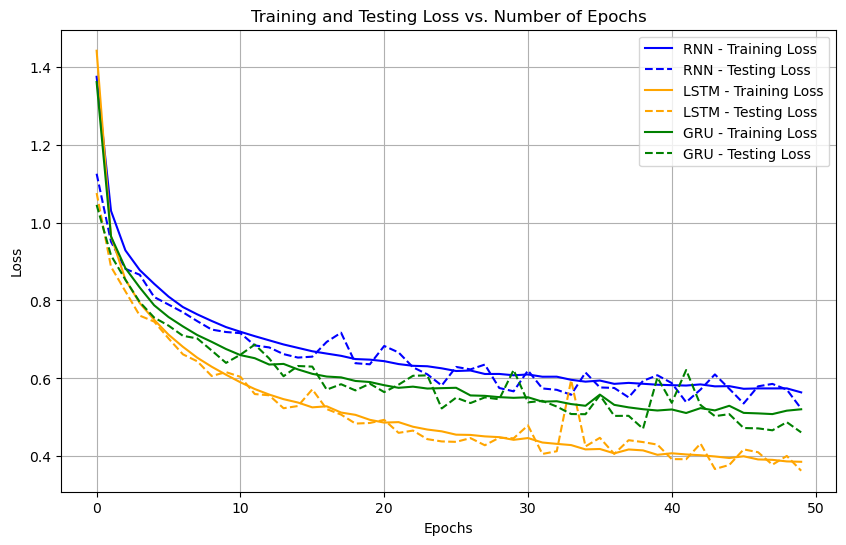

In [ ]:
def plot_loss_all_models(rnn_history, lstm_history, gru_history):
    plt.figure(figsize=(10, 6))

    # Plot Training and Testing Loss for RNN
    plt.plot(rnn_history.history['loss'], label='RNN - Training Loss', color='blue')
    plt.plot(rnn_history.history['val_loss'], label='RNN - Testing Loss', color='blue', linestyle='--')

    # Plot Training and Testing Loss for LSTM
    plt.plot(lstm_history.history['loss'], label='LSTM - Training Loss', color='orange')
    plt.plot(lstm_history.history['val_loss'], label='LSTM - Testing Loss', color='orange', linestyle='--')

    # Plot Training and Testing Loss for GRU
    plt.plot(gru_history.history['loss'], label='GRU - Training Loss', color='green')
    plt.plot(gru_history.history['val_loss'], label='GRU - Testing Loss', color='green', linestyle='--')

    plt.title('Training and Testing Loss vs. Number of Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of plotting for all three models
plot_loss_all_models(rnn_history, lstm_history, gru_history)


In [ ]:
# Predict for all sentences (not just the first 10)
rnn_prediction = stacked_rnn.predict(tmp_x)  # Predict with RNN model
lstm_prediction = stacked_lstm.predict(tmp_x)  # Predict with LSTM model
gru_prediction = stacked_gru.predict(tmp_x)  # Predict with GRU model

# Convert logits to text for the entire prediction (for all sentences)
rnn_translations = [logits_to_text(pred, french_tokenizer) for pred in rnn_prediction]
lstm_translations = [logits_to_text(pred, french_tokenizer) for pred in lstm_prediction]
gru_translations = [logits_to_text(pred, french_tokenizer) for pred in gru_prediction]

# Calculate the accuracy and loss for each model (optional for evaluation)
rnn_loss, rnn_accuracy = stacked_rnn.evaluate(tmp_x, preproc_french_sentences)  # RNN evaluation
lstm_loss, lstm_accuracy = stacked_lstm.evaluate(tmp_x, preproc_french_sentences)  # LSTM evaluation
gru_loss, gru_accuracy = stacked_gru.evaluate(tmp_x, preproc_french_sentences)  # GRU evaluation

# Print the evaluation results
print(f"RNN Loss: {rnn_loss}, RNN Accuracy: {rnn_accuracy}")
print(f"LSTM Loss: {lstm_loss}, LSTM Accuracy: {lstm_accuracy}")
print(f"GRU Loss: {gru_loss}, GRU Accuracy: {gru_accuracy}")

# Display translations for the first 10 sentences from each model (for the report)
print("\nRNN Translations (first 10 sentences):")
for i, trans in enumerate(rnn_translations[:10]):
    print(f"{english_sentences[i]} -> {trans}")

print("\nLSTM Translations (first 10 sentences):")
for i, trans in enumerate(lstm_translations[:10]):
    print(f"{english_sentences[i]} -> {trans}")

print("\nGRU Translations (first 10 sentences):")
for i, trans in enumerate(gru_translations[:10]):
    print(f"{english_sentences[i]} -> {trans}")


4309/4309 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
4309/4309 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
4309/4309 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
4309/4309 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8466 - loss: 0.4816
4309/4309 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8724 - loss: 0.3830
4309/4309 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8032 - loss: 0.6148
RNN Loss: 0.48340171575546265, RNN Accuracy: 0.8460257649421692
LSTM Loss: 0.3858272433280945, LSTM Accuracy: 0.871831476688385
GRU Loss: 0.6172311305999756, GRU Accuracy: 0.802529513835907

RNN Translations (first 10 sentences):
new jersey is sometimes quiet during autumn , and it is snowy in april . -> new jersey est parfois calme en mois automne et il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
the united states is usually chilly during july , and it is usually freezing in november . -> les états unis est généralement froid en juillet et il est généralement en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
calif

In [ ]:
#ONLY TRANSLATED SENTENCE
print("\Original English Sentences (first 10 sentences):")
for i, trans in enumerate(rnn_translations[:10]):
    print(f"{english_sentences[i]}")

print("\nRNN Translations (first 10 sentences):")
for i, trans in enumerate(rnn_translations[:10]):
    print(f"{trans}")

print("\nLSTM Translations (first 10 sentences):")
for i, trans in enumerate(lstm_translations[:10]):
    print(f"{trans}")

print("\nGRU Translations (first 10 sentences):")
for i, trans in enumerate(gru_translations[:10]):
    print(f"{trans}")

\Original English Sentences (first 10 sentences):
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in november .

RNN Translations (first 10 sentences):
new jersey est parfois calme en mois automne et il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
les états unis est généralement froid en jui

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
/var/folders/bf/g5mqnsyx7_91k089_h9wc8mh0000gn/T/ipykernel_57636/1398690070.py:1: SyntaxWarning: invalid escape sequence '\O'
  print("\Original English Sentences (first 10 sentences):")
